# Clean for visualizations

In [1]:
import pandas as pd
from io import StringIO
import datetime
import os
import re

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_colwidth", None) 

In [2]:
crimes = pd.read_csv("bart_crime_updated.csv")
crimes.head()

,description,incident_num,location,agency,date,time
0,DRUG EQUIPMENT VIOLATIONS,2510-0416,2000 BLOCK Mission St,BART Police,10-7-2025,2:08 PM
1,DRUG/NARCOTIC VIOLATIONS,2510-0174,2000 BLOCK Mission St,BART Police,10-3-2025,12:35 PM
2,ALL OTHER LARCENY,2510-0208,2000 BLOCK Mission St,BART Police,10-3-2025,9:40 AM
3,DRUG/NARCOTIC VIOLATIONS,2510-0129,2000 BLOCK Mission St,BART Police,10-2-2025,6:39 PM
4,FALSE PRETENSE/SWINDLE/CONFIDENCE GAME,2510-0032,2000 BLOCK Mission St,BART Police,10-1-2025,1:16 PM


### Clean data

In [3]:
crimes['description'] = crimes['description'].str.lower().str.strip()

crimes['location'] = crimes['location'].str.lower().str.strip()

crimes['incident_num'] = crimes['incident_num'].str.strip()

crimes['agency'] = crimes['agency'].str.lower().str.strip()

crimes['date'] = crimes['date'].str.strip()
crimes['time'] = crimes['time'].str.strip()

crimes['date'] = pd.to_datetime(crimes['date'], format='%m-%d-%Y')
crimes['month_year'] = crimes['date'].dt.strftime('%b %Y')

crimes = crimes.sort_values('date', ascending=False).reset_index(drop=True)

In [4]:
crimes.head()

,description,incident_num,location,agency,date,time,month_year
0,drug equipment violations,2511-0262,2000 block mission st,bart police,2025-11-05,9:57 AM,Nov 2025
1,simple assault,2510-1447,2000 block mission st,bart police,2025-10-23,6:14 PM,Oct 2025
2,intimidation,2510-1179,2000 block mission st,bart police,2025-10-19,10:57 PM,Oct 2025
3,drug equipment violations,2510-1028,2000 block mission st,bart police,2025-10-17,8:03 AM,Oct 2025
4,simple assault,2510-0983,2000 block mission st,bart police,2025-10-16,3:34 PM,Oct 2025


### Graphs 

1. per month all crimes
2. Broken down small multiples column chart 

In [5]:
crimes["description"].value_counts()

description
drug/narcotic violations                    17
drug equipment violations                   12
simple assault                              11
all other larceny                            5
disorderly conduct                           3
intimidation                                 2
destructive/damage/vandalism of property     2
false pretense/swindle/confidence game       1
arson                                        1
Name: count, dtype: int64

In [6]:
descriptions_df = crimes["description"].value_counts().reset_index()
descriptions_df.columns = ['description', 'count']

In [7]:
by_month = crimes["month_year"].value_counts().reset_index()
by_month.columns = ['time', 'count']

In [8]:
descriptions_df.to_csv("viz/bart/crime_desc.csv", index = False)
by_month.to_csv("viz/bart/crime_time.csv", index = False)

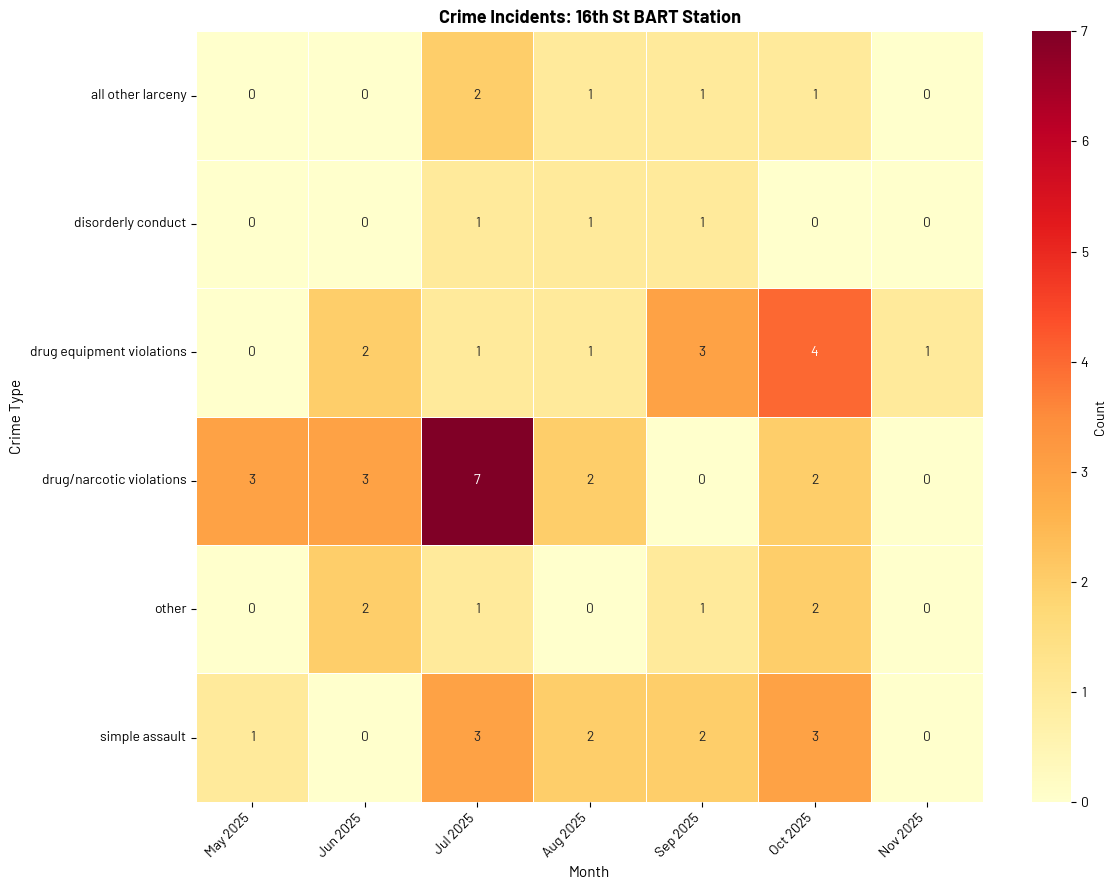

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create directory if it doesn't exist
os.makedirs('viz/bart', exist_ok=True)

# Fix month ordering - convert to datetime and sort
crimes['month_year_dt'] = pd.to_datetime(crimes['month_year'], format='%b %Y')
crimes_sorted = crimes.sort_values('month_year_dt')

# Group rare crimes into "other"
crime_counts = crimes['description'].value_counts()
top_crimes = crime_counts[crime_counts >= 3].index
crimes_sorted['description_grouped'] = crimes_sorted['description'].apply(
    lambda x: x if x in top_crimes else 'other'
)

# Create crosstab with sorted data
heatmap_data = pd.crosstab(
    crimes_sorted['description_grouped'], 
    crimes_sorted['month_year']
)

# Reorder columns chronologically
month_order = crimes_sorted.groupby('month_year')['month_year_dt'].first().sort_values().index
heatmap_data = heatmap_data[month_order]

# Create heatmap - 1200x900 pixels at 100 dpi = 12x9 inches
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'}, linewidths=0.5, ax=ax)

# Set Barlow font for all text elements
ax.set_xlabel('Month', fontsize=11, fontfamily='Barlow')
ax.set_ylabel('Crime Type', fontsize=11, fontfamily='Barlow')
ax.set_title('Crime Incidents: 16th St BART Station', fontsize=13, fontweight='bold', fontfamily='Barlow')

# Set Barlow for tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily('Barlow')

# Set Barlow for colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Count', fontfamily='Barlow')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('viz/bart/crime_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()

In [13]:
import matplotlib.pyplot as plt

# After creating your heatmap, check the fonts
fig = plt.gcf()
for ax in fig.get_axes():
    print("Title font:", ax.title.get_fontname())
    print("X-label font:", ax.xaxis.label.get_fontname())
    print("Y-label font:", ax.yaxis.label.get_fontname())
    print("X-tick fonts:", [t.get_fontname() for t in ax.get_xticklabels()])
    print("Y-tick fonts:", [t.get_fontname() for t in ax.get_yticklabels()])

<Figure size 640x480 with 0 Axes>